In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

In [117]:
df_en= pd.read_csv('data/df_en.csv')
df_en['timestamp'] = pd.to_datetime(df_en['timestamp'],format='%Y%m%d%H')
df_en.set_index('timestamp',inplace=True)

#### Plot raw data daily 

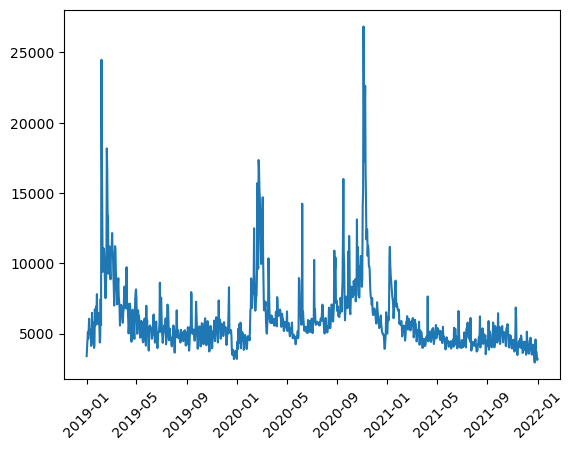

In [118]:
# Choose page 
page = 'Socialism'

plt.plot(df_en.index,df_en[page])
plt.xticks(rotation=45)
plt.show()

#### Plot raw data weekly 

In [119]:
# Turn the daily datas into weekly to have less noise 
df_en_weekly = df_en.groupby(pd.Grouper(level='timestamp', freq='W')).sum()


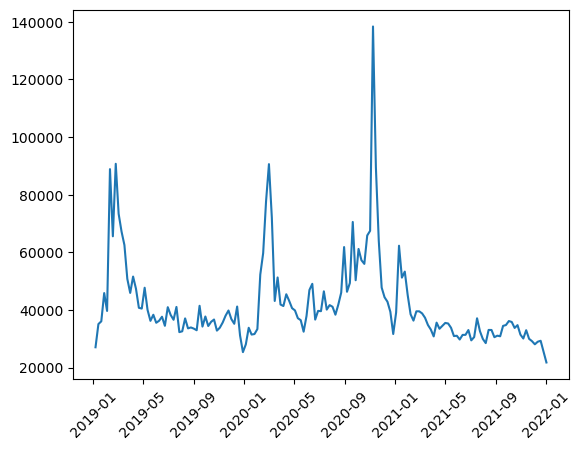

In [120]:
plt.plot(df_en_weekly.index,df_en_weekly[page])
plt.xticks(rotation=45)
plt.show()

#### Drop pages with very fiew views

In [121]:
# Calculate the mean pageviews for each philosophy
mean_pageviews = df_en_weekly.mean()

# Calculate the threshold as 10% of the max mean
threshold = 0.1*mean_pageviews.max()

# Drop columns with a mean below the threshold
df_en_weekly = df_en_weekly.drop(columns=mean_pageviews[mean_pageviews < threshold].index)

In [122]:
df_en_weekly

,Aesthetics,Agnosticism,Anarchism,Anarchy,Animism,Asceticism,Atheism,Authoritarianism,Baptism,Baptists,...,Socialism,Socrates,Stoicism,Structuralism,Taoism,Theology,Transhumanism,Utilitarianism,Zen,Zoroastrianism
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-06,11123.0,21857.0,13544.0,8401.0,9131.0,8449.0,17998.0,7428.0,9163.0,10533.0,...,27074.0,35371.0,22354.0,6380.0,19533.0,6837.0,7459.0,11343.0,11221.0,57548.0
2019-01-13,13692.0,25917.0,20601.0,7955.0,12129.0,10093.0,20912.0,11351.0,14623.0,12235.0,...,35121.0,45865.0,28432.0,10089.0,23945.0,9028.0,8215.0,17115.0,14151.0,62334.0
2019-01-20,14302.0,25382.0,22822.0,8005.0,12370.0,10375.0,19913.0,11666.0,13778.0,12780.0,...,36079.0,45653.0,28405.0,9827.0,26314.0,9776.0,9731.0,19163.0,13503.0,57487.0
2019-01-27,13328.0,29278.0,19095.0,8205.0,11712.0,10380.0,19933.0,10311.0,11689.0,12485.0,...,45873.0,45946.0,26745.0,9675.0,24255.0,9450.0,8151.0,19223.0,13159.0,61678.0
2019-02-03,13268.0,24675.0,18651.0,7606.0,11818.0,10422.0,19988.0,10161.0,11877.0,13180.0,...,39677.0,47998.0,25860.0,9759.0,23298.0,8795.0,8794.0,19405.0,13104.0,60216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,15125.0,16664.0,18512.0,7601.0,12199.0,10225.0,17929.0,12783.0,9929.0,10686.0,...,28102.0,35838.0,35947.0,8702.0,20867.0,7394.0,12192.0,15509.0,11097.0,38242.0
2021-12-12,15344.0,17884.0,18150.0,7358.0,12451.0,10214.0,17218.0,14625.0,9442.0,10723.0,...,28998.0,33772.0,34576.0,8910.0,20754.0,6878.0,12440.0,16668.0,12109.0,38441.0
2021-12-19,14638.0,18557.0,15768.0,6865.0,11883.0,10809.0,16740.0,13293.0,8730.0,10276.0,...,29326.0,31040.0,32108.0,7809.0,20140.0,7121.0,11443.0,14775.0,13966.0,38452.0


In [123]:
# Milestones dates : 
#First case
t0 = '2020-02-16'
#Normalcy 
t1 = '2020-06-21'

### Study of the trend and seasonality 

In [124]:
def plot_seasonal_decomposition(df,subject):
    decompose = seasonal_decompose(df[subject],period=52)
    fig,ax = plt.subplots(4,1,figsize=(7,5))
    ax[0].plot(df[subject],color = 'darkviolet',linewidth=0.75)
    ax[0].set_ylabel('Raw views')
    ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[1].plot(decompose.trend.index,decompose.trend,color='royalblue',linewidth=0.75)
    ax[1].set_ylabel('Trend')
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[2].plot(decompose.seasonal,color='crimson',linewidth=0.75)
    ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[2].set_ylabel('Seasonality')
    ax[3].scatter(decompose.resid.index,decompose.resid,color='grey',linewidth=0.75)
    ax[3].set_ylabel('Residuals')
    ax[3].tick_params(axis='x', which='both', rotation=45, labelbottom=True)
    ax[3].xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
    title = 'Seasonal decomposition : ' + subject
    fig.suptitle(title)


#### A few examples of seasonality decomposition 

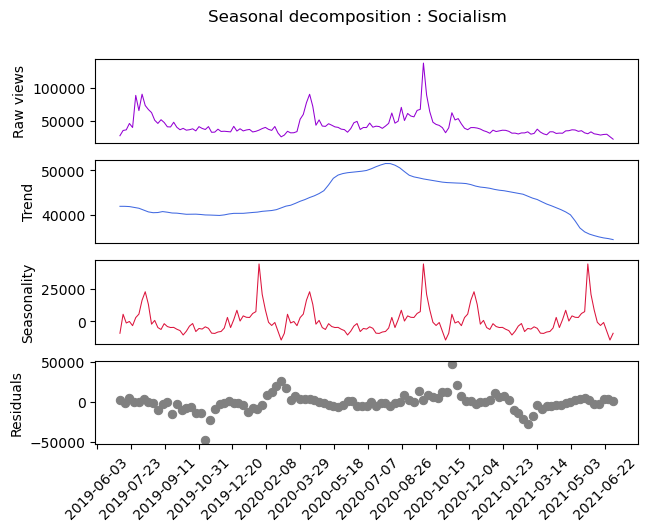

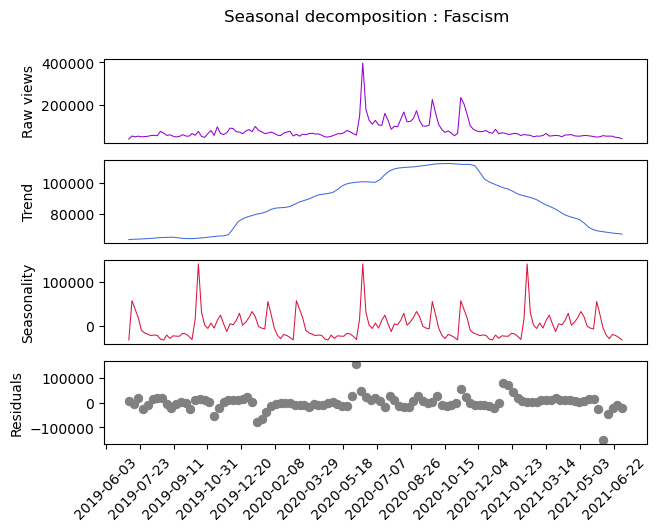

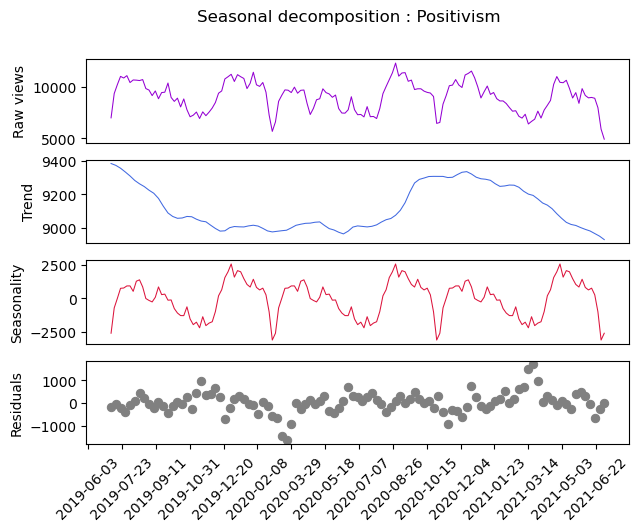

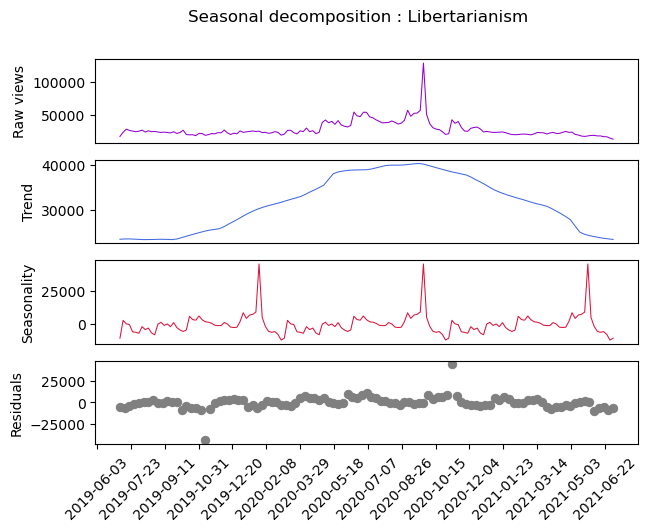

In [125]:
subjects = 'Socialism', 'Fascism','Positivism', 'Libertarianism'
for subject in subjects :
    plot_seasonal_decomposition(df_en_weekly,subject)

### Test with trends and not means 

In [126]:
def diff_percentage(x1,x2): #calculate the percentage diff between absolute values of slopes
    return (np.abs(x2)-np.abs(x1))/np.abs(x1)*100

In [138]:
def plot_regression_on_segments(df,article,segments,threshold,showplot =True):
    
    # Get the trend and plot it 
    decompose_result = seasonal_decompose(df[article],period=52)
    trend = decompose_result.trend
    trend_series = pd.Series(trend)
    if showplot== True :
        plt.plot(trend_series.index[segments[0][0]:segments[2][1]], trend_series[segments[0][0]:segments[2][1]], label='Original Trend',linewidth=0.5)


    # Define the change points
    timepoints = [segments[0][1], segments[1][1]]

    # Initialize useful list 
    change_indices=[]
    slopes =[]
    intercepts=[]

    # Outputs 
    diff_slope = []
    diff_intercept=[]
    type_diff = []


    # Fit segmented regression models and plot the segmented regression lines
    j=0
    for start, end in segments:
        X_segment = add_constant(np.arange(start, end))
        model_segment = OLS(trend_series[start:end], X_segment)
        results_segment = model_segment.fit()
        slopes.append(results_segment.params.iloc[1])
        intercepts.append(results_segment.params.iloc[0])

        if showplot == True :
            plt.plot(trend_series.index[start:end], results_segment.predict(X_segment), label=f'Segment period {j}',linestyle='--',linewidth=1.5)
        j+=1
   
    # Compare slopes and get the intercept difference 
    for i in [0,1]:
        diff= diff_percentage(slopes[i],slopes[i+1])

    # Check conditions : sign of slope and absolute variation, and categorize the slope variation 

        if slopes[i+1]*slopes[i]>0 and diff>0:
            type_diff.append('acceleration') # Reinforcement of the trend 
            if slopes[i]<0:
                diff= -diff # For visualization

        elif slopes[i+1]*slopes[i]>0 and diff<0 :
            type_diff.append('deceleration') # Mitigation of the trend 
            if slopes[i]>0:
                diff=-diff # For visualization
        
        elif slopes[i+1]*slopes[i]<0 :
            type_diff.append('direction change') # Sign change 
            if slopes[i]>0 : 
                diff = -np.abs(diff) # For visualization 
            else :
                diff = np.abs(diff) # For visualization

        
        # Compare the variation to a threshold we consider significant change 
        if diff >threshold or diff<-threshold : 
            change_indices.append(timepoints[i])
        
        diff_slope.append(diff)
        diff_intercept.append(intercepts[i+1]-intercepts[i])

    
    same_indices = list(set(timepoints)-set(change_indices))

    # Mark the points with significant and non significant change 
    if showplot==True : 
        plt.scatter(trend_series.index[change_indices], trend_series.iloc[change_indices], color='red', marker='o', label='Change')
        plt.scatter(trend_series.index[same_indices], trend_series.iloc[same_indices], color='black', marker='x', label='No change')
        plt.title(article)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    return diff_slope,diff_intercept, type_diff



In [139]:
def plot_biggest_change(ax, df, col_to_sort):

    # Positive trends have positive values and negative trends have negative values
    # Top 5 : Highest absolute variation in positive trends 
    # Bottom 5 : Highest absolute variation in negative trends
    # If it is a change of direction : the sign of the slope of the trend after timepoint is taken into consideration 

    df_sorted = df.sort_values(by=col_to_sort, ascending=False)
    top_5 = df_sorted.head(5)
    bottom_5 = df_sorted.tail(5)
    bottom_5 = bottom_5[bottom_5[col_to_sort]<0]
    


    if col_to_sort.__contains__('Intercept') :
        ax.bar(top_5.index, top_5[col_to_sort], color='mediumseagreen')
        ax.bar(bottom_5.index, bottom_5[col_to_sort], color='firebrick') 
        ax.set_ylabel('Difference after-before')

    else : 
        ax.bar(top_5.index, top_5[col_to_sort], color='mediumaquamarine', label='Positive trend')
        ax.bar(bottom_5.index, [-x for x in bottom_5[col_to_sort]], color='indianred', label='Negative trend')   
        ax.set_ylabel('Percentage change')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.legend()

In [152]:
articles = df_en_weekly.columns[1:]
segments = [(38, 58), (58,76), (76, 96)]


trend_changes = pd.DataFrame()
trend_changes['Slope change at t0'] = None
trend_changes['Slope change at t1']=None
trend_changes['Intercept change at t0']=None
trend_changes['Intercept change at t1']=None
trend_changes['Type t0'] = None
trend_changes['Type t1'] = None
for article in articles : 
    diff_slope,diff_intercept,type_trend = plot_regression_on_segments(df_en_weekly,article,segments,30,showplot=False)
    if np.abs(diff_slope[0])>30 or np.abs(diff_slope[1])>30 :
        trend_changes.loc[article] = {'Slope change at t0' : diff_slope[0],'Slope change at t1':diff_slope[1],'Intercept change at t0':diff_intercept[0],'Intercept change at t1':diff_intercept[1],'Type t0':type_trend[0],'Type t1':type_trend[1]}


In [154]:
trend_acc_0 = trend_changes[trend_changes['Type t0']=='acceleration']
trend_dec_0 = trend_changes[trend_changes['Type t0']=='deceleration']
trend_dir_0 = trend_changes[trend_changes['Type t0']=='direction change']
trend_acc_1 = trend_changes[trend_changes['Type t1']=='acceleration']
trend_dec_1 = trend_changes[trend_changes['Type t1']=='deceleration']
trend_dir_1 = trend_changes[trend_changes['Type t1']=='direction change']

/var/folders/1d/mrjskb4j41jdty_41nyblpxw0000gn/T/ipykernel_72562/2929551699.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


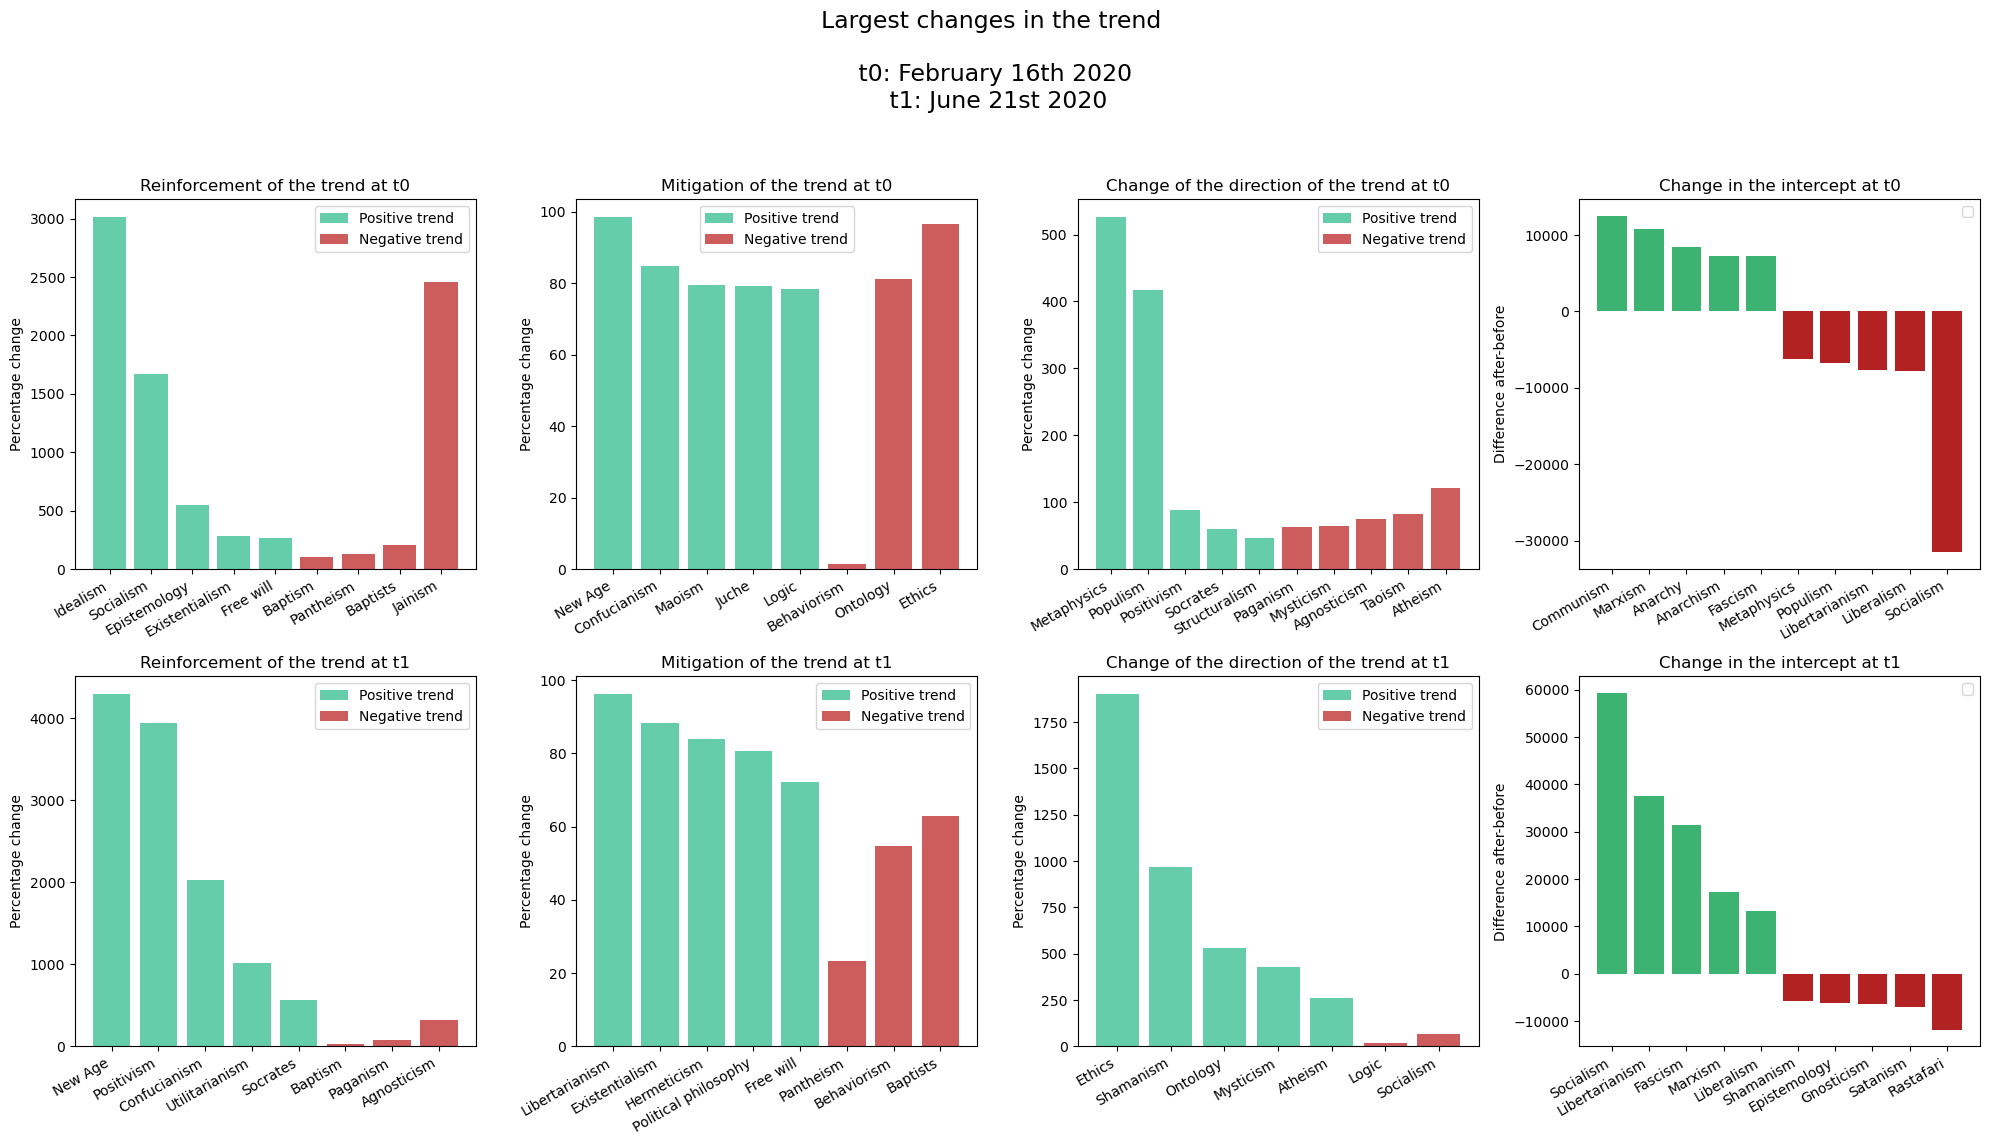

In [155]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Largest changes in the trend \n\n t0: February 16th 2020 \n t1: June 21st 2020', fontsize=17)
# Flatten the axes if subplot_config is a 2D layout
axes = axes.flatten() if isinstance(axes[0], (list, np.ndarray)) else axes

# Define the column names you want to plot
columns_to_plot = ['Slope change at t0',  'Intercept change at t0','Slope change at t1','Intercept change at t1']


plot_biggest_change(axes[0], trend_acc_0, 'Slope change at t0')
axes[0].set_title('Reinforcement of the trend at t0')
plot_biggest_change(axes[1], trend_dec_0, 'Slope change at t0')
axes[1].set_title('Mitigation of the trend at t0')
plot_biggest_change(axes[2], trend_dir_0, 'Slope change at t0')
axes[2].set_title('Change of the direction of the trend at t0')
plot_biggest_change(axes[3], trend_changes, 'Intercept change at t0')
axes[3].set_title('Change in the intercept at t0')
plot_biggest_change(axes[4], trend_acc_1, 'Slope change at t1')
axes[4].set_title('Reinforcement of the trend at t1')
plot_biggest_change(axes[5], trend_dec_1, 'Slope change at t1')
axes[5].set_title('Mitigation of the trend at t1')
plot_biggest_change(axes[6], trend_dir_1, 'Slope change at t1')
axes[6].set_title('Change of the direction of the trend at t1')
plot_biggest_change(axes[7], trend_changes, 'Intercept change at t1')
axes[7].set_title('Change in the intercept at t1')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
plt.show()

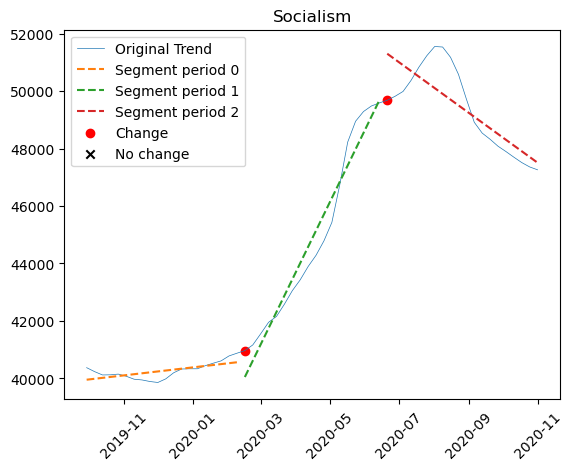

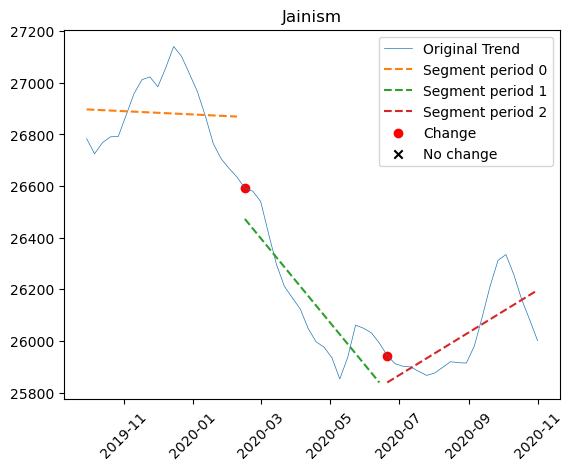

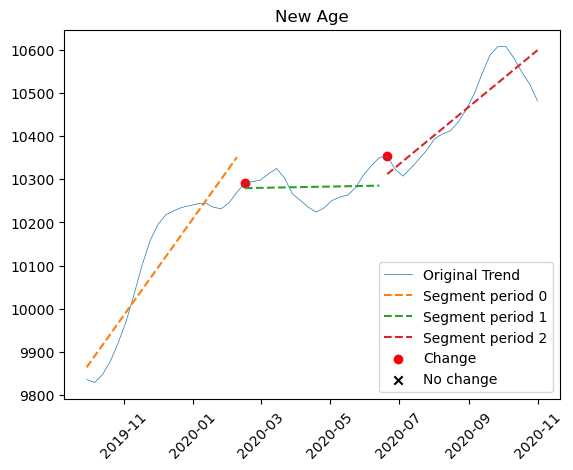

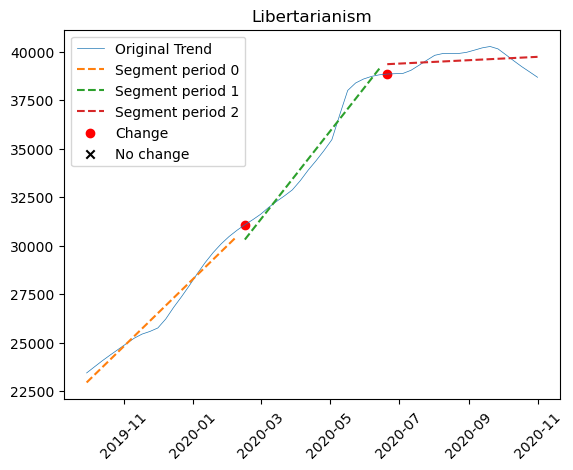

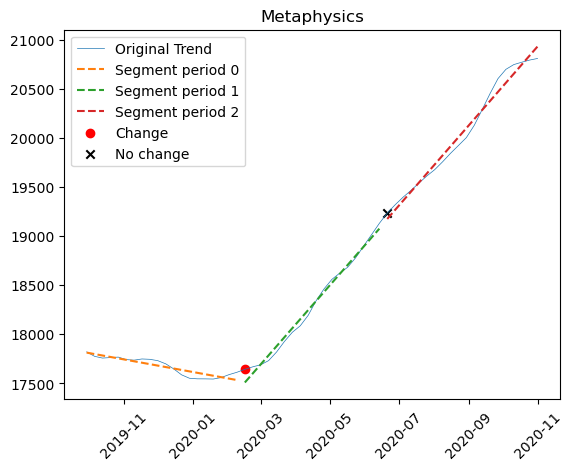

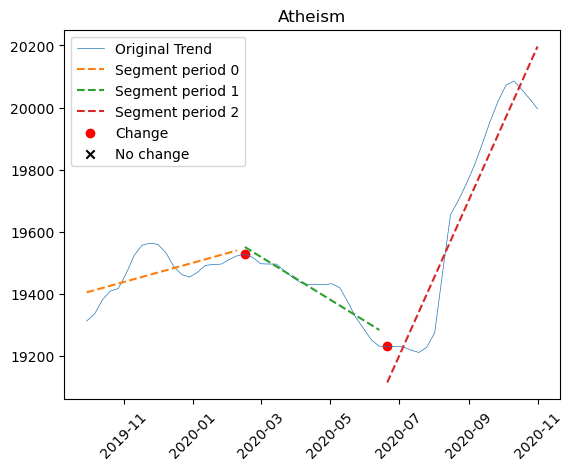

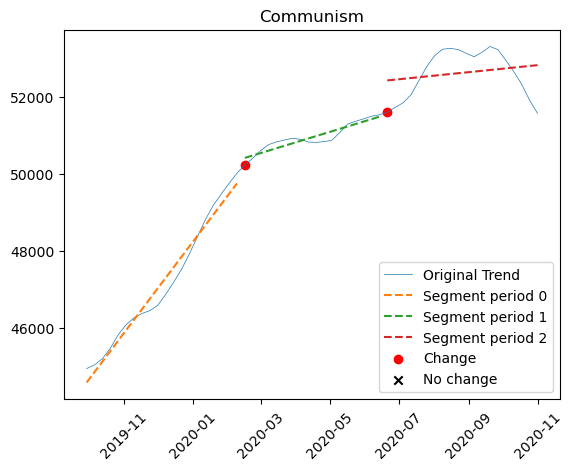

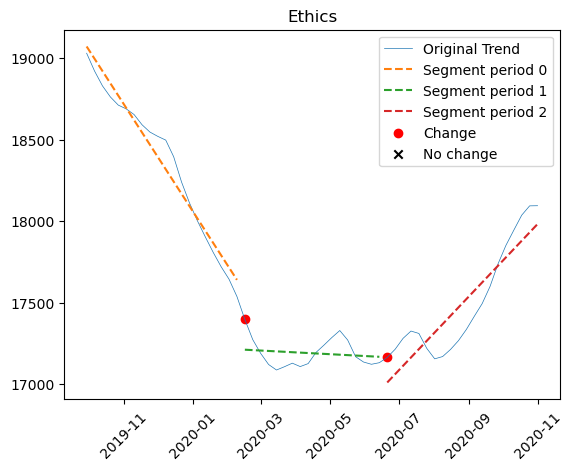

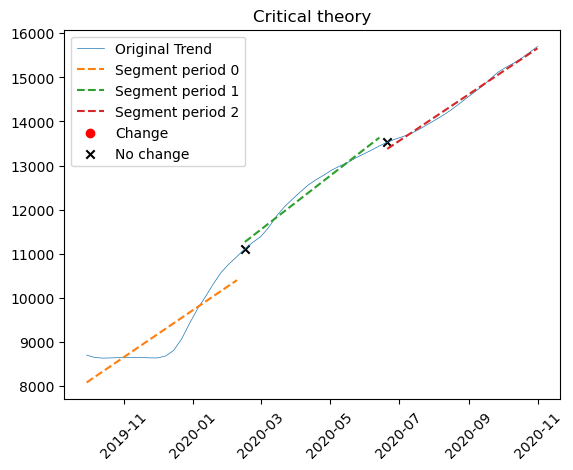

In [133]:
subjects_changed = ['Socialism','Jainism','New Age','Libertarianism','Metaphysics','Atheism','Communism','Ethics','Critical theory']
for subject in subjects_changed : 
    plot_regression_on_segments(df_en_weekly,subject,segments,30)